In [16]:
import torch as t
from pizza_clock.dataset import AdditionDataset
from pizza_clock.training import ModularAdditionModelTrainer
from torch.utils.data import DataLoader, random_split
from torch import Tensor, nn
from jaxtyping import Float
import einops
import os
import json
import pandas as pd
from collections import defaultdict, namedtuple
import wandb


In [22]:
def parse_name(name: str):
    # Name looks like p113_attn1.0_td0.8_wd2.0_seed4.
    parts = name.split("_")
    params = {}
    for part in parts:
        if part.startswith("p"):
            params["p"] = int(part[1:])
        elif part.startswith("attn"):
            params["attention_rate"] = float(part[4:])
        elif part.startswith("td"):
            params["train_data_fraction"] = float(part[3:])
        elif part.startswith("wd"):
            params["weight_decay"] = float(part[2:])
        elif part.startswith("seed"):
            params["seed"] = int(part[4:])
    return params

names_and_ids = pd.read_csv("wandb_export_2026-01-22T16_23_22.764+01_00.csv")
runs = []
for row in names_and_ids.iterrows():
    name, id = row[1]
    params = parse_name(name)
    runs.append({"name": name, "id": id, **params})
runs_df = pd.DataFrame(runs)


In [18]:
Params = namedtuple("Params", ["p", "attention_rate", "train_data_fraction", "weight_decay"])
api = wandb.Api()


In [23]:
def update_run_configs(runs_df: pd.DataFrame):
    for _, row in runs_df.iterrows():
        # run is specified by <entity>/<project>/<run_id>
        run = api.run(f"gahanna999-/modular-addition-attention-grokking-sweep/{row['id']}")
        run.config["p"] = row["p"]
        run.config["attention_rate"] = row["attention_rate"]
        run.config["train_data_fraction"] = row["train_data_fraction"]
        run.config["weight_decay"] = row["weight_decay"]
        run.update()
        params = Params(
            p=row["p"],
            attention_rate=row["attention_rate"],
            train_data_fraction=row["train_data_fraction"],
            weight_decay=row["weight_decay"],
        )
update_run_configs(runs_df)

name                   p113_attn1.0_td0.8_wd2.0_seed4
id                                           0xd9gbyg
p                                                 113
attention_rate                                    1.0
train_data_fraction                               0.8
weight_decay                                      2.0
seed                                                4
Name: 0, dtype: object
2.0
name                   p113_attn0.0_td0.8_wd2.0_seed4
id                                           gmvrrnz0
p                                                 113
attention_rate                                    0.0
train_data_fraction                               0.8
weight_decay                                      2.0
seed                                                4
Name: 1, dtype: object
2.0
name                   p113_attn1.0_td0.8_wd1.5_seed4
id                                           u3t1vjnp
p                                                 113
attention_rate              

KeyboardInterrupt: 

In [ ]:
# Plot runs based on parameters (excluding seed) and average the metrics. One plot should include all runs for a given parameter setup.
train_loss_histories = defaultdict(list)
val_loss_histories = defaultdict(list)
val_accuracy_histories = defaultdict(list)

for _, row in runs_df.iterrows():
    run = api.run(f"gahanna999-/modular-addition-attention-grokking-sweep/{row['id']}")
    history = run.scan_history(keys=["train loss", "val loss", "val accuracy"])
    train_loss_history = [row["train loss"] for row in history]
    val_loss_history = [row["val loss"] for row in history]
    val_accuracy_history = [row["val accuracy"] for row in history]
    train_loss_histories[params].append(train_loss_history)
    val_loss_histories[params].append(val_loss_history)
    val_accuracy_histories[params].append(val_accuracy_history)

In [8]:
train_loss_histories

defaultdict(list,
            {Params(p=113, attention_rate=1.0, train_data_fraction=0.8, weight_decay=0.0): [[4.740658283233643,
               4.724549293518066,
               4.704065799713135,
               4.6810383796691895,
               4.646491050720215,
               4.590967655181885,
               4.493972301483154,
               4.292283535003662,
               3.820039987564087,
               3.0325145721435547,
               1.8411952257156372,
               0.678109884262085,
               0.16065320372581482,
               0.04264161363244057,
               0.019276585429906845,
               0.014121826738119125,
               0.013438137248158455,
               0.013999461196362972,
               0.014457469806075096,
               0.014182094484567642,
               0.013132432475686073,
               0.011643434874713421,
               0.010081970132887363,
               0.008676127530634403,
               0.007490580901503563,
              

In [9]:
with open("train_loss_histories.txt", "w") as f:
    f.write(json.dumps({str(k): v for k, v in train_loss_histories.items()}))
with open("val_loss_histories.txt", "w") as f:
    f.write(json.dumps({str(k): v for k, v in val_loss_histories.items()}))
with open("val_accuracy_histories.txt", "w") as f:
    f.write(json.dumps({str(k): v for k, v in val_accuracy_histories.items()}))

In [11]:
import matplotlib.pyplot as plt

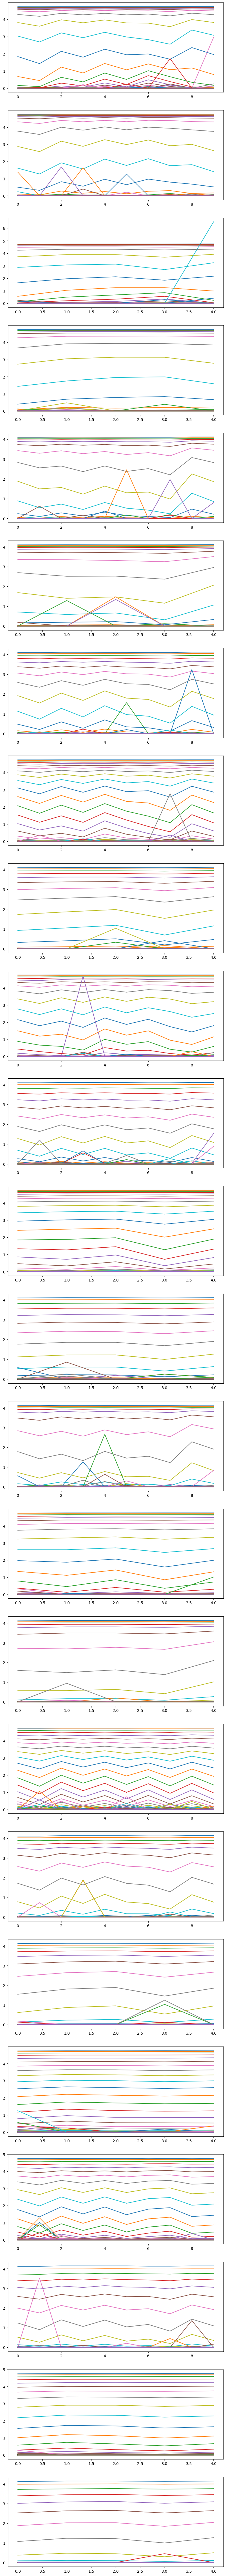

In [15]:
# For each set of parameters, plot the train loss history for all seeds in one subplot. Make sure, they are separate subplots!
fig, axes = plt.subplots(len(train_loss_histories), 1, figsize=(10, 5 * len(train_loss_histories)))
for ax, (key, value) in zip(axes, train_loss_histories.items()):
    ax.plot(value, label=f"Params: {key}")
    # ax.set_title(f"Train Loss - {key}")
    # ax.set_xlabel("Step")
    # ax.set_ylabel("Loss")
    # ax.legend(fontsize="small", loc="best")
